<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Population" data-toc-modified-id="Population-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Population</a></span></li><li><span><a href="#Covid-19" data-toc-modified-id="Covid-19-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Covid-19</a></span></li><li><span><a href="#Particulate-Matter" data-toc-modified-id="Particulate-Matter-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Particulate Matter</a></span><ul class="toc-item"><li><span><a href="#Interpolation" data-toc-modified-id="Interpolation-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Interpolation</a></span></li></ul></li></ul></li><li><span><a href="#Risk" data-toc-modified-id="Risk-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Risk</a></span></li></ul></div>

# Imports

In [655]:
import numpy as np
import xarray as xr
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd
import regionmask
import matplotlib.gridspec as gridspec
import imageio
import os

from PIL import Image
sns.set('paper','dark','muted', 'sans-serif', 2, color_codes=True)

cborders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='ne_admin_0_countries',
        scale='10m',
        facecolor='none')
eu_countries = regionmask.defined_regions.natural_earth.countries_50


# Data

## Population

<IPython.core.display.Javascript object>


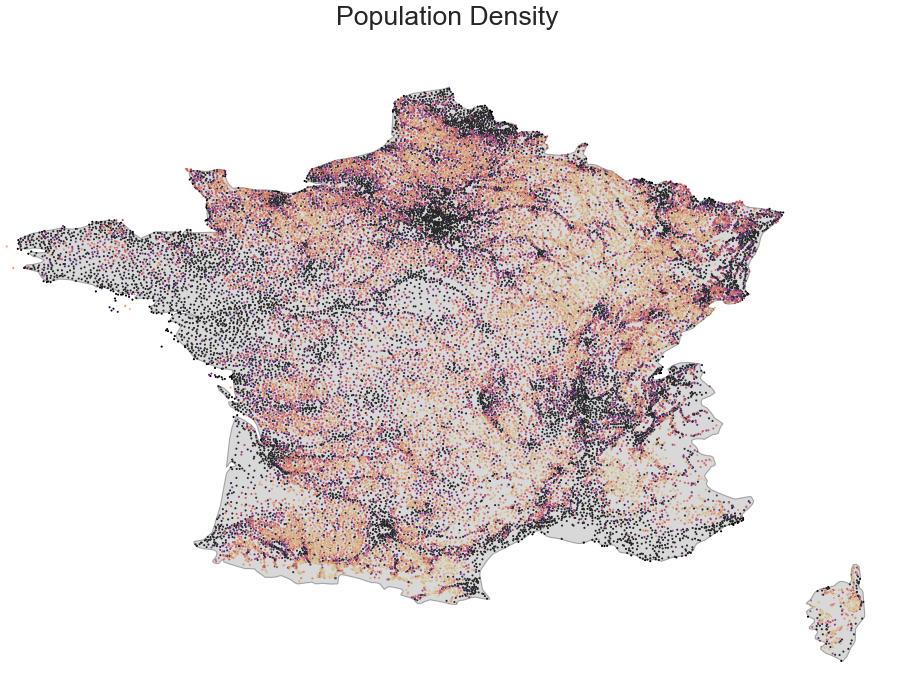

/home/nrieger/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


In [656]:
pop = pd.read_csv('./../data/pop/pop_fr.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.set_extent([-5,10,41,52])
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)

sc = ax.scatter(pop.lon,pop.lat,c=pop.total,s=.5, vmin=0, vmax=1000, cmap='magma_r')
#ax.scatter(dep.lon,dep.lat,c=dep.total,s=50, vmin=0, vmax=1000000, cmap='RdBu_r')
#fig.colorbar(sc,ax=ax)
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.005,right=0.99,top=0.97)
plt.title('Population Density')
plt.tight_layout()
plt.show()


In [105]:
def normalize(x):
    return 0.5 + (x - x.min()) / (x.max() - x.min())


pop['logtotal'] = np.log10(pop['total'])
pop['totalNorm'] = normalize(pop['total'])  
pop['logtotalNorm'] = normalize(pop['logtotal'])  

popDEP = pop.copy().groupby('dep').mean()
popDEP['total'] = popfr.groupby('dep').sum()['total']
popDEP['logtotal'] = np.log10(popDEP['total'])
popDEP['totalNorm'] = normalize(popDEP['total'])
popDEP['logtotalNorm'] = normalize(popDEP['logtotal'])

plt.figure(figsize=(9,9))
popDEP.logtotalNorm.hist()
plt.title('Normalized Population Index')
plt.tight_layout()
plt.show()

KeyError: 'total'

## Covid-19

In [658]:
%matplotlib notebook
covid = pd.read_csv('./../data/covid/covid_fr.csv', sep=';').dropna()
covid = covid[covid.sexe==0]
covid = covid[covid['jour'] == '2020-10-14']
covid['dep'] = covid['dep'].replace({'2A':'201','2B':'202'}).astype(int)
test = pop[['dep','lon','lat']].drop_duplicates(subset=['dep'])
covid['lon'] = [test[test['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['dep']]
covid['lat'] = [test[test['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['dep']]
covid = covid[:-5]


#covidExtra (extrapolation of Covid data to communité level)
covidExtra = pop.copy()
covidExtra['hosp'] = [covid[covid['dep'] == depNum].hosp.values.squeeze() for depNum in covidExtra['dep']]

<IPython.core.display.Javascript object>


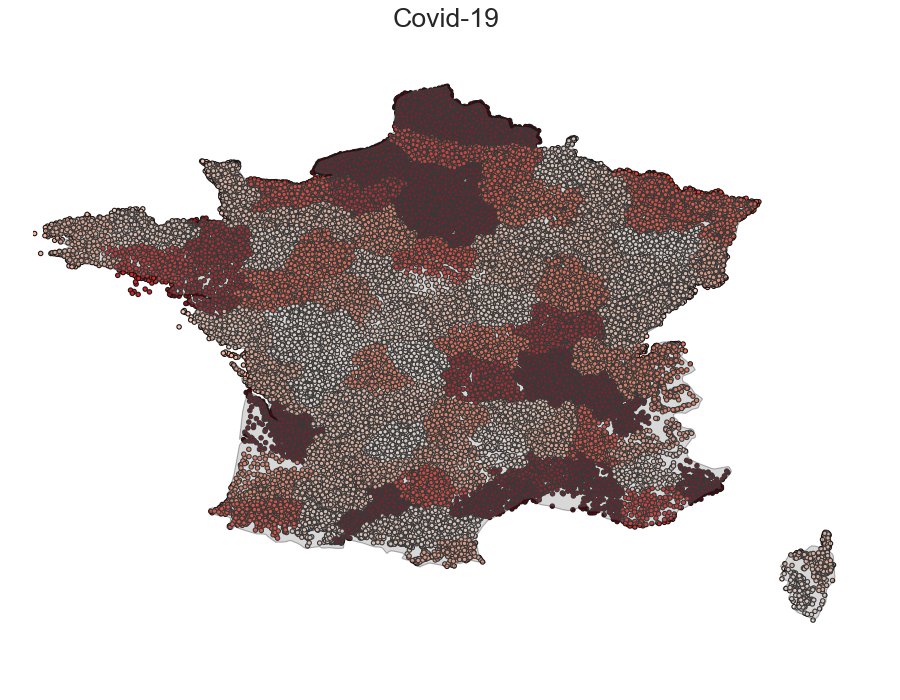

/home/nrieger/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


In [659]:
fig = plt.figure(figsize=(9,7))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.coastlines('10m', lw=.5)
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
ax.set_extent([-5,10,40,52])
#ax.scatter(covid.lon.values,covid.lat.values,c=covid.hosp.values,s=100,edgecolor='k', vmin=0, vmax=100, cmap='Reds')
ax.scatter(covidExtra.lon.values,covidExtra.lat.values,c=covidExtra.hosp.values,s=10,edgecolor='k', vmin=0, vmax=100, cmap='Reds')

ax.set_title('Covid-19')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)

plt.tight_layout()
plt.show()


## Particulate Matter

In [660]:
pm25 = xr.open_dataset('./../data/pm/pm25.nc')
pm25 = pm25.pm2p5_conc.drop('level').squeeze() #.sortby(['longitude'])
pm25.coords['longitude'] = (pm25.coords['longitude'] + 180) % 360 - 180
pm25 = pm25.sortby('longitude')
pm25 = pm25.sel(longitude=slice(-10,10),latitude=slice(55,40))

<IPython.core.display.Javascript object>


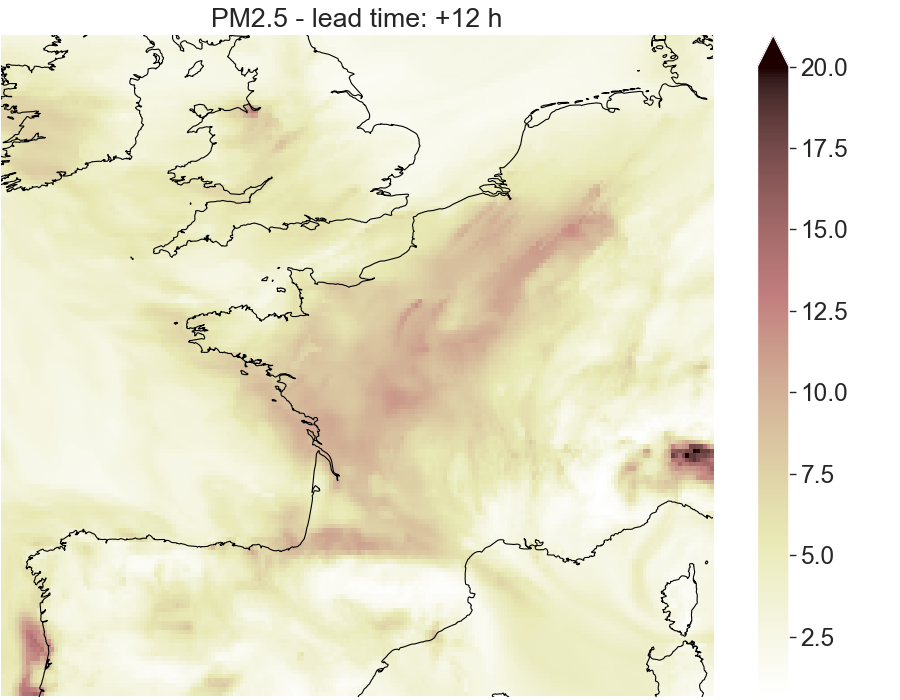

interactive(children=(IntSlider(value=0, description='time', max=96), Output()), _dom_classes=('widget-interac…

In [661]:
wtime = widgets.IntSlider(value=0,min=0,max=96)

images=[]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines('10m')
#eu_countries['F','D'].plot(ax=ax,add_label=False,resolution='10m')
#pm25[0].plot(ax=ax, vmax=15, cmap='RdBu_r')
im = pm25[0].plot.imshow(ax=ax, cmap='pink_r', vmax=20, cbar_kwargs={'label':''})
ax.set_extent([-10,10,40,55])
ax.set_title('', fontdict={'fontsize': '25',
                     'fontweight' : '3'})

ax.set_aspect('auto')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)


def plot(time):
    im.set_data(pm25[time])
    ax.set_title('PM2.5 - lead time: {:+} h'.format(time))
    images.append(im)

    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = '/home/nrieger//Transfer/workshops/2020-10 Barcelona Hackathon/data/' + str(time) + '_pm25.jpg'
    plt.savefig(filepath, dpi=120)
    
    
widgets.interactive(plot,time=wtime)

### Interpolation

In [ ]:
resolution = 10

x,y = pop.lon[::resolution], pop.lat[::resolution]

pms =[]
for i in range(0,96):
    print(100*i/96)
    pmScatter = np.array([pm25[i].interp(longitude=lon,latitude=lat).values for lon,lat in zip(x,y)])
    pmScatter = np.vstack((x,y,pmScatter)).T
    pmScatter = pd.DataFrame(pmScatter, columns=['lon','lat','pm25'])
    
    pms.append(pmScatter)

0.0
1.0416666666666667
2.0833333333333335
3.125
4.166666666666667
5.208333333333333
6.25
7.291666666666667
8.333333333333334
9.375
10.416666666666666
11.458333333333334
12.5
13.541666666666666
14.583333333333334
15.625
16.666666666666668
17.708333333333332
18.75
19.791666666666668
20.833333333333332
21.875
22.916666666666668
23.958333333333332
25.0
26.041666666666668
27.083333333333332
28.125
29.166666666666668
30.208333333333332
31.25
32.291666666666664
33.333333333333336
34.375
35.416666666666664
36.458333333333336
37.5
38.541666666666664
39.583333333333336
40.625
41.666666666666664
42.708333333333336
43.75
44.791666666666664
45.833333333333336
46.875
47.916666666666664
48.958333333333336
50.0
51.041666666666664
52.083333333333336
53.125
54.166666666666664
55.208333333333336
56.25
57.291666666666664
58.333333333333336
59.375
60.416666666666664
61.458333333333336
62.5
63.541666666666664
64.58333333333333
65.625
66.66666666666667
67.70833333333333
68.75
69.79166666666667
70.83333333333

# Risk

$$
\text{Risk} = \text{Hazard} \times \text{Vulnerability} \times \text{Exposure}
$$

In [757]:
riskMaps = []
for i in range(0,3):

    risk =  normalize(pms[i].pm25).values * pop.logtotalNorm[::resolution].values * normalize(covidExtra.hosp[::resolution])
    risk = np.vstack((x,y,risk)).T
    risk = pd.DataFrame(risk,columns=['lon','lat','risk'])
    
    riskMaps.append(risk)

<IPython.core.display.Javascript object>


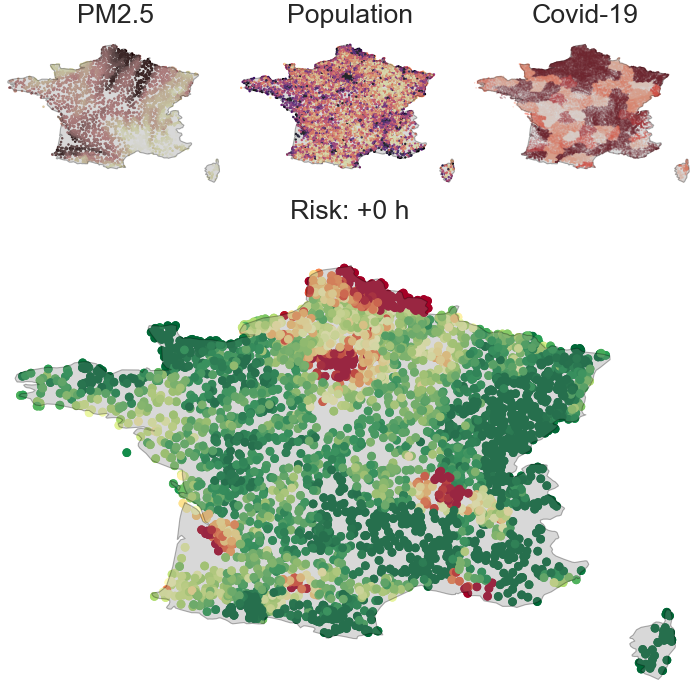

interactive(children=(IntSlider(value=0, description='time', max=2), Output()), _dom_classes=('widget-interact…

In [788]:
wtime2 = widgets.IntSlider(value=0,min=0,max=2)

fig = plt.figure(constrained_layout=True, figsize=(7,7))
gs = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
axes = [ax1,ax2,ax3,ax4]

for a in axes:
    a.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

sc1 = ax1.scatter(pms[0].lon,pms[0].lat,c=pms[0].pm25, cmap='pink_r', s=1, vmax=10)
ax1.set_title('PM2.5')
        
ax2.scatter(pop.lon[::4],pop.lat[::4],c=pop.logtotal[::4],s=.8, vmin=2, vmax=4, cmap='magma_r')
ax2.set_title('Population')

ax3.scatter(covidExtra.lon,covidExtra.lat,c=covidExtra.hosp,s=.01, vmin=0, vmax=50, cmap='Reds')
ax3.set_title('Covid-19')

scrisk = ax4.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].risk, cmap='RdYlGn_r', s=30, vmin=0.4, vmax=1)
ax4.set_title('Risk')



#fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)


def plot(time):
    sc1.set_array(pms[time].pm25)
    ax4.scatter(riskMaps[time].lon,riskMaps[time].lat,c=riskMaps[time].risk, cmap='RdYlGn_r', s=30, vmin=0.4, vmax=1)
    ax4.set_title('Risk: {:+} h'.format(time))
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = '/home/nrieger//Transfer/workshops/2020-10 Barcelona Hackathon/data/' + str(time) + '_risk.jpg'
    fig.savefig(filepath, dpi=120)
    pass
    
widgets.interactive(plot,time=wtime2)

In [106]:
def normalize(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std

In [87]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'ensemble',
        'date': '2021-03-27/2021-03-29',
        'format': 'netcdf',
        'variable': 'particulate_matter_2.5um',
        'level': '0',
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': '95',
    },
    'download.nc')



2021-03-29 15:38:23,914 INFO Welcome to the CDS
2021-03-29 15:38:23,915 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2021-03-29 15:38:23,939 INFO Request is queued
2021-03-29 15:38:24,961 INFO Request is running
2021-03-29 15:38:28,751 INFO Request is completed
2021-03-29 15:38:28,752 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data7/adaptor.cams_regional_fc.retrieve-1617025109.589075-20398-16-ecf761e8-7842-412d-a20a-630f8d2e169a.nc to download.nc (3.4M)
2021-03-29 15:38:29,030 INFO Download rate 12.2M/s  


Result(content_length=3533752,content_type=application/x-netcdf,location=https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data7/adaptor.cams_regional_fc.retrieve-1617025109.589075-20398-16-ecf761e8-7842-412d-a20a-630f8d2e169a.nc)

<xarray.Dataset>
Dimensions:     (latitude: 150, level: 8, longitude: 200, time: 1)
Coordinates:
  * longitude   (longitude) float32 -9.950012 -9.849976 ... 9.850006 9.949997
  * latitude    (latitude) float32 54.95 54.85 54.75 54.65 ... 40.25 40.15 40.05
  * level       (level) float32 0.0 50.0 250.0 500.0 1000.0 2000.0 3000.0 5000.0
  * time        (time) timedelta64[ns] 00:00:00
Data variables:
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at 8 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20210329+[0H_0H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at 8 l...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)


<ipython-input-89-51dfe03f6949>:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.)


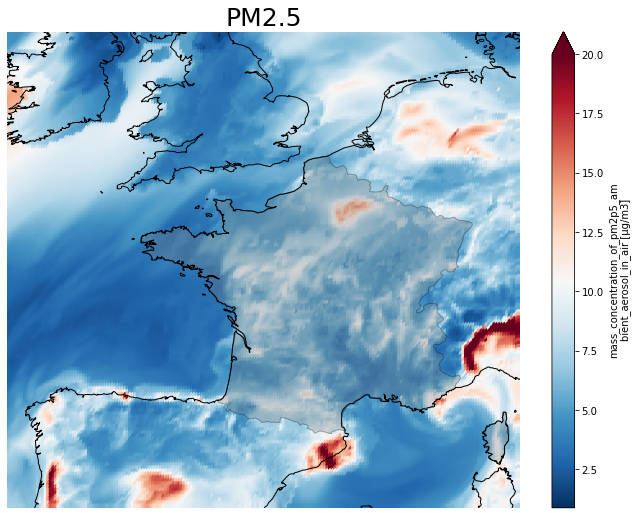

In [89]:
import ipywidgets as widgets
from ipywidgets import interactive
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl
import xarray as xr
import regionmask

eu_countries = regionmask.defined_regions.natural_earth.countries_50


pm25 = xr.open_dataset('pm25automated.nc') #.sortby(['longitude'])
#pm25 = pm25.pm2p5_conc.drop('level').squeeze() #.sortby(['longitude'])
pm25.coords['longitude'] = (pm25.coords['longitude'] + 180) % 360 - 180
pm25 = pm25.sortby('longitude')
pm25 = pm25.sel(longitude=slice(-10,10),latitude=slice(55,40))
print(pm25)
pm25 = pm25.isel(level=0, time =0)

wtime = widgets.IntSlider(value=0,min=0,max=96)

images=[]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
ax.coastlines('10m')
im = pm25.plot.scatter("longitude","latitude", hue = "pm2p5_conc", vmax=20, cmap='RdBu_r')
ax.set_extent([-10,10,40,55])
ax.set_title('PM2.5', fontdict={'fontsize': '25',
                     'fontweight' : '3'})

ax.set_aspect('auto')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)



6.35028933229975


<ipython-input-5-0dcaa09fec0a>:11: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.)


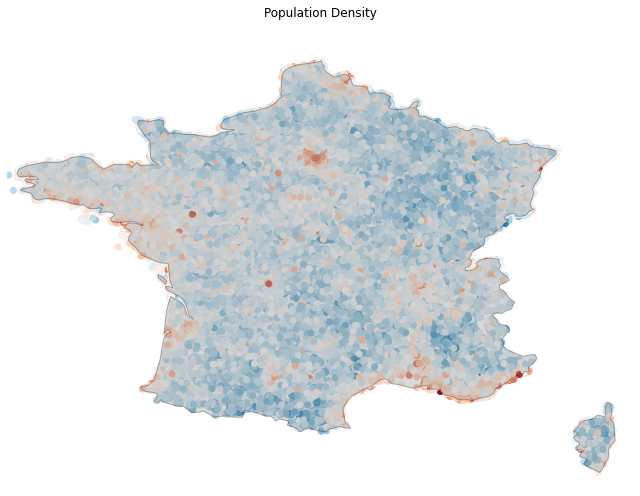

In [5]:
import pandas as pd
import numpy as np
pop = pd.read_csv('popfr2010.csv',sep = ";")
pop["pop_2010"]=np.log10(pop["pop_2010"])
print(max(pop["pop_2010"]))
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
ax.set_extent([-5,10,41,52])
sc = ax.scatter(pop.long,pop.lat,c = pop.pop_2010, vmin=0, vmax=6.36, cmap='RdBu_r')
ax.outline_patch.set_linewidth(0.)
ax.set_aspect('auto')
fig.subplots_adjust(bottom=0.005,left=0.005,right=0.99,top=0.97)
plt.title('Population Density')
plt.tight_layout()
plt.show()

In [8]:
import requests

departements = pd.read_csv("departements-francais.csv", sep = ";")
hospi = []
url = "https://coronavirusapi-france.now.sh/AllLiveData"
response = requests.get(url).json()
counter = 0
for numero in departements.NUMÉRO:
    nom = str(departements[departements["NUMÉRO"]==numero]["NOM"].values[0])
    hospi.append((nom, numero, response["allLiveFranceData"][counter]["hospitalises"]))
    counter+=1

In [9]:
hospidf = pd.DataFrame(hospi)
hospidf.columns = ["DepName","DepNb","Hospitalisations"]


In [10]:
hospidf['DepNb'] = hospidf['DepNb'].replace({'2A':'201','2B':'202'}).astype(int)
hospidf['DepNb'] = hospidf['DepNb'].astype(int)
test = pop[['dep','long','lat']].drop_duplicates(subset=['dep'])
hospidf['long'] = [test[test['dep']==int(depNum)].long.values.squeeze() for depNum in hospidf['DepNb']]
hospidf['lat'] = [test[test['dep']==int(depNum)].lat.values.squeeze() for depNum in hospidf['DepNb']]
#covid = covid[:-5]
#covidExtra (extrapolation of Covid data to communité level)
covidExtra = pop.copy()
covidExtra['hosp'] = [hospidf[hospidf['DepNb'] == depNum].Hospitalisations.values.squeeze() for depNum in covidExtra['dep']]

<ipython-input-11-2a94bd994e88>:10: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.)


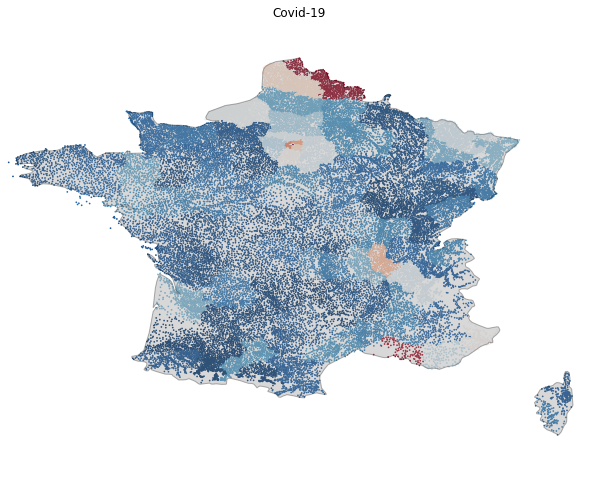

In [11]:
fig = plt.figure(figsize=(9,7))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.coastlines('10m', lw=.5)
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
ax.set_extent([-5,10,40,52])
sc = ax.scatter(covidExtra.long,covidExtra.lat,c = covidExtra.hosp,s=.5, vmin=0, vmax=1456, cmap='RdBu_r')

ax.set_title('Covid-19')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)

plt.tight_layout()
plt.show()


In [92]:
pm252 = pm25.to_array()

In [93]:
resolution = 10

x,y = pop.long[::resolution], pop.lat[::resolution]
pmScatter = np.array([pm252.interp(longitude=long,latitude=lat).values for long,lat in zip(x,y)])
pmScatter = np.vstack((x,y,pmScatter[0::,0])).T
pmScatter = pd.DataFrame(pmScatter, columns=['long','lat','pm25'])


In [146]:
from sklearn.preprocessing import RobustScaler
transformer1 = RobustScaler().fit(pmScatter[["pm25"]])
transformer2 = RobustScaler().fit(pop[["pop_2010"]][::resolution])
transformer3 = RobustScaler().fit(covidExtra[["hosp"]][::resolution])
risk = normalize(transformer1.transform(pmScatter[["pm25"]]))* normalize(transformer2.transform(pop[["pop_2010"]][::resolution])) * normalize(transformer3.transform(covidExtra[["hosp"]][::resolution]))
risk = np.vstack((x,y,risk[0::,0],pop.pop_2010[::resolution])).T
risk = pd.DataFrame(risk,columns=['lon','lat','risk','pop'])
    

In [148]:
risk

,lon,lat,risk,pop
0,2.352222,48.856614,0.289341,6.350289
1,2.590160,48.877535,0.100338,4.736177
2,3.237548,48.969526,0.135266,2.886598
3,2.974530,49.007185,0.165794,3.257301
4,2.960128,48.648117,0.081795,3.127318
...,...,...,...,...
3627,9.299449,42.527426,0.007235,1.925015
3628,9.430600,42.876100,0.009188,2.294758
3629,9.474762,42.277097,0.005144,2.541031
3630,9.175371,42.254707,0.012725,2.551841


In [156]:
maxrisk

0.28934145187631943

In [155]:
maxrisk = risk["risk"].max()

<ipython-input-157-7f6b3297f3cb>:14: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  a.outline_patch.set_linewidth(0.)


Text(0.5, 1.0, 'Risk')

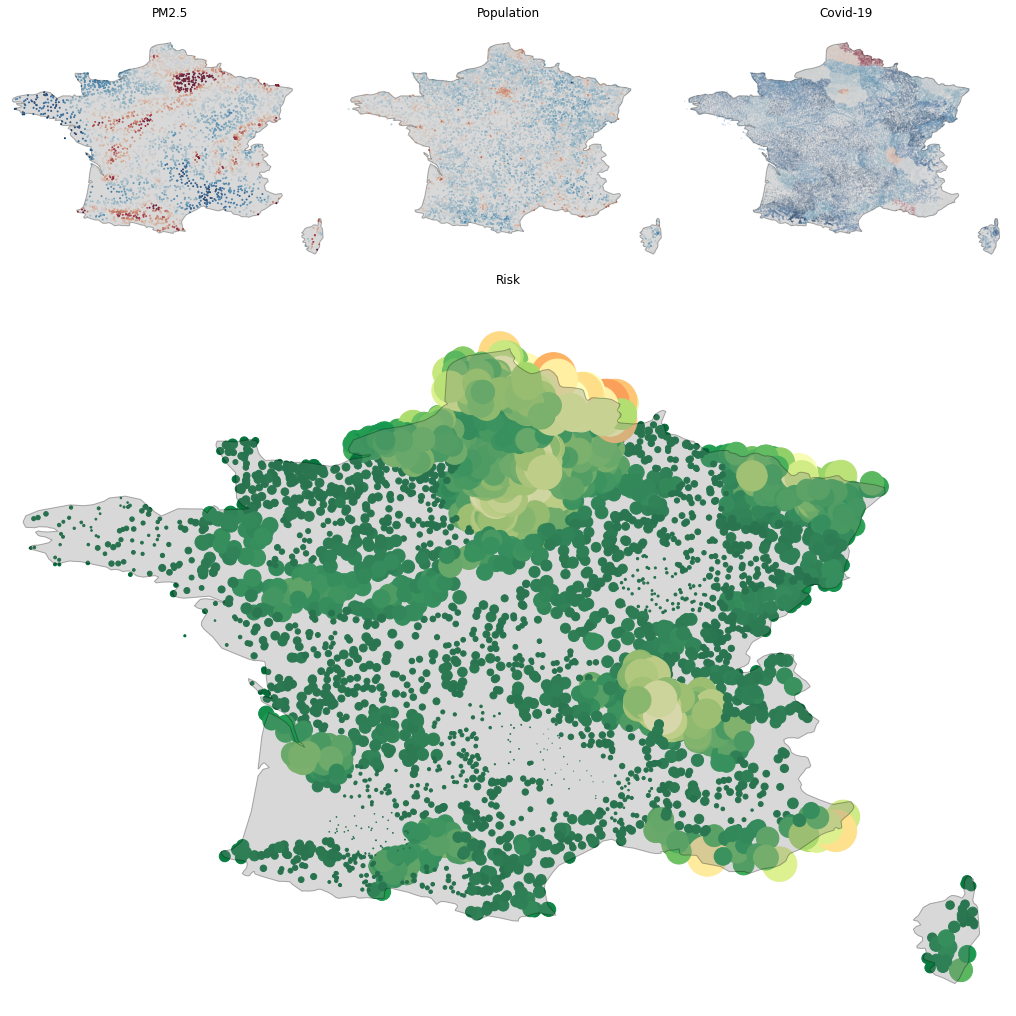

In [157]:
fig = plt.figure(constrained_layout=True, figsize=(14,14))
gs = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
axes = [ax1,ax2,ax3,ax4]

for a in axes:
    a.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
    #a.set_extent([-5,10,41,52])
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

sc1 = ax1.scatter(pmScatter.long,pmScatter.lat,c=pmScatter.pm25, cmap='RdBu_r', s=1, vmax=10)
ax1.set_title('PM2.5')
        
ax2.scatter(pop.long[::4],pop.lat[::4],c=pop.pop_2010[::4],s=.8, vmin=0, vmax=6.36, cmap='RdBu_r')
ax2.set_title('Population')

ax3.scatter(covidExtra.long,covidExtra.lat,c=covidExtra.hosp,s=.01, vmin=0, vmax=1456, cmap='RdBu_r')
ax3.set_title('Covid-19')

scrisk = ax4.scatter(risk.lon,risk.lat,c=risk.risk, cmap='RdYlGn_r', s=10000*risk.risk, vmin=0, vmax=maxrisk)
ax4.set_title('Risk')